In [2]:
# Import necessary libraries
import yfinance as yf  # Fetch stock market data
import pandas as pd  # Data manipulation
import numpy as np  # Numerical operations
import talib  # Technical indicators
from sklearn.ensemble import RandomForestClassifier  # Machine Learning model
from sklearn.model_selection import train_test_split, GridSearchCV  # Model selection
from sklearn.metrics import accuracy_score  # Performance evaluation
import backtrader as bt  # Backtesting library
import matplotlib.pyplot as plt #MatplotLib for visualizations
import logging


In [3]:
# Function to get stock data
def get_data(ticker, start, end):
    df = yf.download(ticker, start=start, end=end)
    if df.empty:
        return None
    # Keep only necessary columns
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    df.dropna(inplace=True)
    return df

In [4]:
# Function to calculate RSI, MACD, and Bollinger Bands
def add_indicators(df):
    if df is None or 'Close' not in df.columns:
        raise ValueError("Invalid DataFrame: Missing 'Close' column")
    print("DataFrame shape:", df.shape)
    #print("Close column type:", df['Close'].dtype)
    print("Close column values:\n", df['Close'].head())

    # Forward fill missing values
    df['Close'] = df['Close'].ffill()
    # Ensure 'Close' column is a proper NumPy array
    close_prices = df['Close'].values.astype(np.float64).flatten()
    print("Close prices shape:", close_prices.shape)
    print("Close prices type:", close_prices.dtype)

    # Compute RSI
    df['RSI'] = talib.RSI(close_prices, timeperiod=14)
    
    # Compute MACD and MACD Signal Line
    macd, macdsignal, _ = talib.MACD(close_prices, fastperiod=12, slowperiod=26, signalperiod=9)
    df['MACD'] = macd
    df['MACD_Signal'] = macdsignal
    
    # Compute Bollinger Bands (Upper & Lower)
    upper, middle, lower = talib.BBANDS(close_prices, timeperiod=20)
    df['BB_Upper'] = upper
    df['BB_Lower'] = lower
    
    # Drop NaN values after calculating indicators
    df.dropna(inplace=True)
    return df

In [5]:
# Function to create the target variable
def create_target_var(df):
    df['Target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)
    df.dropna(inplace=True)
    return df

In [6]:
# Function to train the machine learning model
def train_model(df):
    # Define feature columns
    features = ['RSI', 'MACD', 'MACD_Signal', 'BB_Upper', 'BB_Lower']

    # Ensure all features exist in df
    if any(feature not in df.columns for feature in features):
        raise ValueError("Missing features in dataframe")

    # Split data into training and testing sets
    X = df[features]  # Feature matrix
    y = df['Target']  # Target variable
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define Random Forest model with hyperparameter tuning
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 10]}
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')
    grid_search.fit(X_train, y_train)  # Train model

    # Select best model and evaluate performance
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))  # Print accuracy

    return best_model

In [7]:
# Define a Backtrader strategy that uses the trained model
class MLStrategy(bt.Strategy):
    def __init__(self, model, df):
        self.model = model  # Store trained ML model
        self.dataframe = df  # Store historical data with indicators
        self.order = None  # Store current order state

    def next(self):
        # Ensure we don't exceed available data
        current_date = self.datas[0].datetime.date(0)
        if current_date in self.dataframe.index:
            idx = self.dataframe.index.get_loc(current_date)

            # Extract feature values safely
            features = ['RSI', 'MACD', 'MACD_Signal', 'BB_Upper', 'BB_Lower']
            data_point = self.dataframe.loc[self.dataframe.index[idx], features].values.reshape(1, -1)

            # Make prediction and act accordingly
            prediction = self.model.predict(data_point)
            if prediction[0] == 1 and not self.position:
                self.buy()
            elif prediction[0] == 0 and self.position:
                self.sell()

[*********************100%***********************]  1 of 1 completed


DataFrame shape: (250, 5)
Close column values:
 Ticker            AAPL
Date                  
2023-01-03  123.632530
2023-01-04  124.907707
2023-01-05  123.583099
2023-01-06  128.130234
2023-01-09  128.654114
Close prices shape: (250,)
Close prices type: float64
DataFrame info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 217 entries, 2023-02-21 to 2023-12-29
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Open, AAPL)     217 non-null    float64
 1   (High, AAPL)     217 non-null    float64
 2   (Low, AAPL)      217 non-null    float64
 3   (Close, AAPL)    217 non-null    float64
 4   (Volume, AAPL)   217 non-null    int64  
 5   (RSI, )          217 non-null    float64
 6   (MACD, )         217 non-null    float64
 7   (MACD_Signal, )  217 non-null    float64
 8   (BB_Upper, )     217 non-null    float64
 9   (BB_Lower, )     217 non-null    float64
 10  (Target, )       217 non-null    int64  

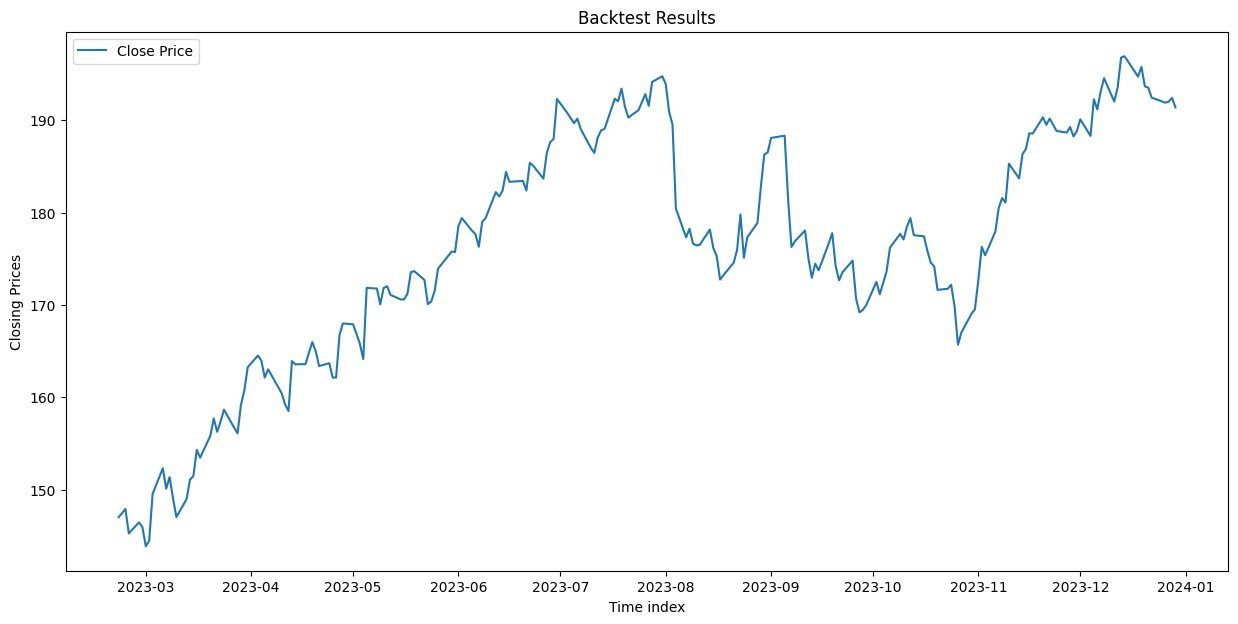

In [9]:
# Fetch and process stock data
df = get_data('AAPL', '2023-01-01', '2024-01-01')

if df is not None:
    df = add_indicators(df) # Add technical indicators
    df = create_target_var(df) # Create target variable
    print("DataFrame info:")
    print(df.info())
    print("DataFrame columns:", df.columns)
    print("Type of df.columns:", type(df.columns))
    print("DataFrame head:\n", df.head())
    
    # Check for NaN or Inf values
    print("NaN values:")
    print(df.isna().sum())
    print("Inf values:")
    print(np.isinf(df).sum())
    
    if isinstance(df, pd.DataFrame):
        model = train_model(df) # Train ML model
        
        # Convert MultiIndex to simple Index
        df.columns = ['_'.join(col).strip() for col in df.columns.values]
        
        print("DataFrame columns after conversion:", df.columns)
        print("DataFrame head after conversion:\n", df.head())
        
        # Check for NaN or Inf values after conversion
        print("NaN values after conversion:")
        print(df.isna().sum())
        print("Inf values after conversion:")
        print(np.isinf(df).sum())
        
        # Set up Backtrader for backtesting
        cerebro = bt.Cerebro()
        print("Cerebro object:", cerebro)
        data = bt.feeds.PandasData(dataname=df)
        print("Data feed object:", data)
        
        cerebro.adddata(data)
        cerebro.addstrategy(MLStrategy, model=model, df=df)

        # Run backtesting
        results = cerebro.run()

        # Modify plotting settings and plot
        %matplotlib inline
        strategy = results[0]
        plt.figure(figsize=(15, 7))
        plt.plot(df.index, df['Close_AAPL'], label='Close Price')
        plt.xlabel("Time index")
        plt.ylabel("Closing Prices")
        plt.title('Backtest Results')
        plt.legend()
        plt.show()
        
    else:
        print("Error: df is not a pandas DataFrame. Type of df:", type(df))
else:
    print("Failed to fetch data. Check the ticker symbol or date range.")